# Klasifikasi Gambar

## Import Library

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from PIL import Image

import zipfile
import os
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Load Dataset

In [3]:
kagglehub.login()

In [4]:
# Download dataset
!kaggle datasets download --force ilhamhasib/vehicle-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/ilhamhasib/vehicle-classification-dataset
License(s): CC-BY-SA-4.0




  0%|          | 0.00/4.38G [00:00<?, ?B/s]
  0%|          | 1.00M/4.38G [00:01<1:25:39, 915kB/s]
  0%|          | 2.00M/4.38G [00:01<1:01:25, 1.28MB/s]
  0%|          | 3.00M/4.38G [00:02<58:18, 1.34MB/s]  
  0%|          | 4.00M/4.38G [00:03<51:52, 1.51MB/s]
  0%|          | 5.00M/4.38G [00:03<51:49, 1.51MB/s]
  0%|          | 6.00M/4.38G [00:04<55:50, 1.40MB/s]
  0%|          | 7.00M/4.38G [00:04<45:50, 1.71MB/s]
  0%|          | 8.00M/4.38G [00:05<38:49, 2.01MB/s]
  0%|          | 9.00M/4.38G [00:05<34:42, 2.25MB/s]
  0%|          | 10.0M/4.38G [00:05<32:39, 2.39MB/s]
  0%|          | 11.0M/4.38G [00:06<30:52, 2.53MB/s]
  0%|          | 12.0M/4.38G [00:06<29:45, 2.63MB/s]
  0%|          | 13.0M/4.38G [00:07<29:55, 2.61MB/s]
  0%|          | 14.0M/4.38G [00:07<34:21, 2.27MB/s]
  0%|          | 15.0M/4.38G [00:08<36:25, 2.14MB/s]
  0%|          | 16.0M/4.38G [00:08<33:32, 2.33MB/s]
  0%|          | 17.0M/4.38G [00:08<30:43, 2.54MB/s]
  0%|          | 18.0M/4.38G [00:09<29:57, 2.61MB

In [ ]:
# Ekstrak dataset
zip_path = 'vehicle-classification-dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
extracted_folder = [f for f in os.listdir() if os.path.isdir(f)]
print(extracted_folder)

['Car-Classification-Data-with-Labels-iHasib', 'Vehicle Test Data']


## Mengecek Resolusi Gambar

In [21]:
# Path to the train directory
train_dir = extracted_folder[0]+'/train'

# Dictionary to store image resolutions
image_resolutions = {}

# Counter to limit the number of images processed
image_count = 0
max_images = 10

# Iterate through each subfolder and image file
for subdir, _, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png')):
            file_path = os.path.join(subdir, file)
            with Image.open(file_path) as img:
                image_resolutions[file_path] = img.size
                image_count += 1
                if image_count >= max_images:
                    break

# Print the resolutions
for path, resolution in image_resolutions.items():
    print(f'{path}: {resolution}')

Car-Classification-Data-with-Labels-iHasib/train\0.jpg: (1734, 978)
Car-Classification-Data-with-Labels-iHasib/train\1.jpg: (4608, 3456)
Car-Classification-Data-with-Labels-iHasib/train\10.jpg: (2280, 2865)
Car-Classification-Data-with-Labels-iHasib/train\100.jpg: (3456, 4608)
Car-Classification-Data-with-Labels-iHasib/train\1000.jpg: (3456, 4608)
Car-Classification-Data-with-Labels-iHasib/train\1001.jpg: (3456, 4608)
Car-Classification-Data-with-Labels-iHasib/train\1002.jpg: (3456, 4608)
Car-Classification-Data-with-Labels-iHasib/train\1003.jpg: (3456, 4608)
Car-Classification-Data-with-Labels-iHasib/train\1004.jpg: (3456, 4608)
Car-Classification-Data-with-Labels-iHasib/train\1005.jpg: (4160, 3120)


## Labeling Data

In [16]:
# Load the labels
labels_df = pd.read_csv('Car-Classification-Data-with-Labels-iHasib/type-labels.csv')
labels_df.head(10)

,ID,Type
0,0,Bike
1,1,Bike
2,2,Bike
3,3,Bike
4,4,Bike
5,5,Bike
6,6,Bike
7,7,Bike
8,8,Bike
9,9,Bike


In [ ]:
# Create directories for each label
for label in labels_df['Type'].unique():
    label_dir = os.path.join(train_dir, label)
    os.makedirs(label_dir, exist_ok=True)

# Move images to corresponding label directories
for index, row in labels_df.iterrows():
    img_id = row['ID']
    label = row['Type']
    src_path = os.path.join(train_dir, f'{img_id}.jpg')
    dst_path = os.path.join(train_dir, label, f'{img_id}.jpg')
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)

## Augmentasi Gambar

In [27]:
# Create an ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    # rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Create a generator for the training data
train_generator = train_datagen.flow_from_directory(
    'Car-Classification-Data-with-Labels-iHasib/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create a generator for the validation data
validation_generator = train_datagen.flow_from_directory(
    'Car-Classification-Data-with-Labels-iHasib/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5187 images belonging to 10 classes.
Found 1293 images belonging to 10 classes.


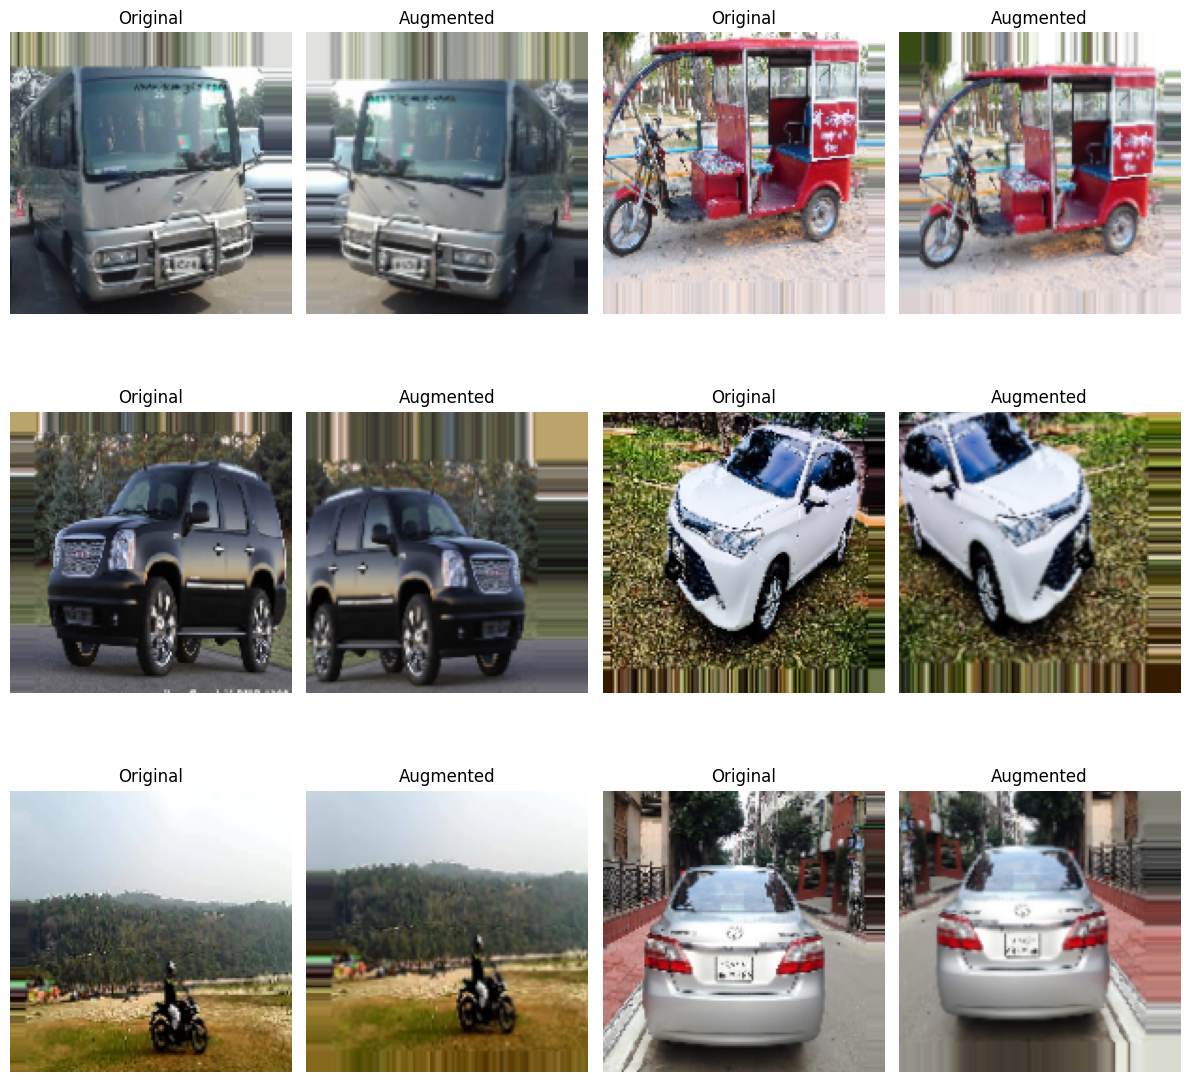

In [29]:
# Ambil batch gambar dari train_generator
images, labels = next(train_generator)

# Tampilkan beberapa gambar asli dan hasil augmentasi
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 4, 2*i+1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.axis('off')

    # Augmentasi gambar
    augmented_image = train_datagen.random_transform(images[i])
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(augmented_image)
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')  # Assuming there are 3 classes
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])



## Define the Model

In [30]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (2,2), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [31]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
# Define Callback
from keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") >= 0.95:
            print("Reached 95% accuracy. Stopping training...")
            self.model_stop_training = True

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks = StopTrainingCallback()
)

Epoch 1/10


c:\Users\khair\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  7/162 ━━━━━━━━━━━━━━━━━━━━ 12:48 5s/step - accuracy: 0.1421 - loss: 5.3835